# Logistic Regression Demo

This notebook begins introducing the logistic regression.

## Setup

Let's import some packages:

In [45]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [56]:
rng = np.random.RandomState(20201022)

## Read Data

In [46]:
students = pd.read_csv("https://stats.idre.ucla.edu/stat/data/binary.csv")
students.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Let's train and test:

In [57]:
test = students.sample(frac=0.2, random_state=rng)

In [58]:
train_mask = pd.Series(True, index=students.index)
train_mask[test.index] = False
train = students[train_mask].copy()
train.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Train the Model

Now we'll a GLM model:

In [59]:
mod = smf.glm('admit ~ gre + gpa + rank', train,
              family=sm.families.Binomial())
lg_res = mod.fit()
lg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  320
Model:                            GLM   Df Residuals:                      316
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -185.53
Date:                Thu, 22 Oct 2020   Deviance:                       371.06
Time:                        19:51:37   Pearson chi2:                     321.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1575      1.231     -2.566      0.010      -5.570      -0.745
gre            0.0025      0.001      2.092      0.036       0.000       0.005
gpa            0.6554      0.352      1.862      0.063      -0.035       1.345
rank          -0.5566      0.141     -3.935      0.000      -0.834      -0.279
==============================================================================
"""

Let's generate scores for the *train* data:

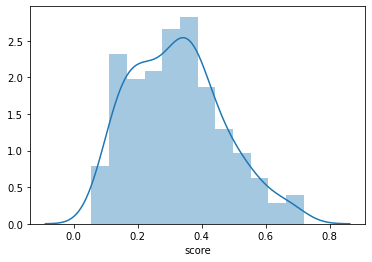

In [60]:
train['score'] = lg_res.predict(train)
sns.distplot(train['score'])

Let's compute the likelihood of each observed outcome:

In [61]:
train['like'] = train['score'].pow(train['admit']) 
train['like'] *= (1 - train['score']).pow(1 - train['admit'])
train.head()

,admit,gre,gpa,rank,score,like
0,0,380,3.61,3,0.182807,0.817193
1,1,660,3.67,3,0.321259,0.321259
2,1,800,4.00,1,0.718391,0.718391
3,1,640,3.19,4,0.158440,0.158440
4,0,520,2.93,4,0.104835,0.895165


What is the likelhood of all the data?

In [62]:
train['like'].prod()

2.659838384326594e-81

That's small! Let's compute log likelihoods.

In [63]:
train['log_like'] = train['admit'] * np.log(train['score'])
train['log_like'] += (1 - train['admit']) * np.log(1 - train['score'])
train.head()

,admit,gre,gpa,rank,score,like,log_like
0,0,380,3.61,3,0.182807,0.817193,-0.201880
1,1,660,3.67,3,0.321259,0.321259,-1.135508
2,1,800,4.00,1,0.718391,0.718391,-0.330741
3,1,640,3.19,4,0.158440,0.158440,-1.842378
4,0,520,2.93,4,0.104835,0.895165,-0.110747


Total log likelihood:

In [64]:
train['log_like'].sum()

-185.5311271693419

That matches the log likelihood from the GLM fit process.

What is the accuracy on the training data using 0.5 as our decision threshold:

In [65]:
np.mean(train['admit'] == (train['score'] > 0.5))

0.7

## Analysis with Test Data

Now we'll predict our test data:

In [66]:
test['score'] = lg_res.predict(test)
test.head()

,admit,gre,gpa,rank,score
45,1,460,3.45,3,0.197909
377,1,800,4.00,2,0.593855
322,0,500,3.01,4,0.104995
227,0,540,3.02,4,0.115585
391,1,660,3.88,2,0.486557


What are the highest-scored and lowest-scored items?

In [67]:
test.nlargest(5, 'score')

,admit,gre,gpa,rank,score
12,1,760,4.00,1,0.697421
69,0,800,3.73,1,0.681253
14,1,700,4.00,1,0.664381
206,0,740,3.54,1,0.618418
106,1,700,3.56,1,0.597365


In [68]:
test.nsmallest(5, 'score')

,admit,gre,gpa,rank,score
102,0,380,3.33,4,0.096431
166,0,440,3.24,4,0.104861
322,0,500,3.01,4,0.104995
179,0,300,3.01,3,0.109722
227,0,540,3.02,4,0.115585


Let's make decisions with a threshold of 0.5.

In [69]:
test['decision'] = test['score'] > 0.5
test.head()

,admit,gre,gpa,rank,score,decision
45,1,460,3.45,3,0.197909,False
377,1,800,4.00,2,0.593855,True
322,0,500,3.01,4,0.104995,False
227,0,540,3.02,4,0.115585,False
391,1,660,3.88,2,0.486557,False


What is the **accuracy** of these decisions?

In [70]:
(test['admit'] == test['decision']).mean()

0.7375

Let's compute the confusion matrix:

In [71]:
out_counts = test.groupby(['decision', 'admit'])['score'].count()
out_counts

decision  admit
False     0        52
          1        17
True      0         4
          1         7
Name: score, dtype: int64

In [72]:
out_counts.unstack()

admit,0,1
decision,,
False,52,17
True,4,7


What is the recall?  TP / (TP + FN)

In [73]:
out_counts.loc[True, 1] / (out_counts.loc[True, 1] + out_counts.loc[False, 1])

0.2916666666666667

Using column/row sums:

In [74]:
out_counts.loc[True, 1] / out_counts.loc[:, 1].sum()

0.2916666666666667